In [39]:
# Basic libraries import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
# tkinter GUI import
import tkinter as tk1
from tkinter.filedialog import askopenfilename

In [41]:
# Debugger import library if required
from IPython.core.debugger import set_trace

In [42]:
# Import filename interactively
root = tk1.Tk()
#root.lift()
root.attributes("-topmost", True)
root.withdraw()
filename = askopenfilename()
root.destroy()

In [43]:
# Read the raw dataframe and read 'obu_timestamp' column as datetime format
data = pd.read_csv(filename,
                   parse_dates=['obu_timestamp'])

In [44]:
# Add an index column to the created dataframe
data.reset_index(level=0, inplace=True)

In [45]:
# Verify dataframe dtypes and column entries
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7357 entries, 0 to 7356
Columns: 120 entries, index to fuel_level
dtypes: datetime64[ns](1), float64(107), int64(8), object(4)
memory usage: 6.7+ MB


In [46]:
# Peep into the first 5 lines of data
data.head(5)

,index,S_No,obu_id,obu_timestamp,packet_sequence_id,p_frequency,latitude,longitude,altitude,heading,...,aft1_intake_nox,aft1_intake_nox_reading_stable,aft1_intermediate_gas,dpf1_regen_needed,low_adblue_level_warning,eng_requested_torque_limit,pf_actreginh_dueto,aftertreatment1_outlet_nox,vin,fuel_level
0,0,1,1911271039,2020-06-22 02:57:20,0,NaN,22.482629,70.048222,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MB1A3GCDXLRFE0093,NaN
1,1,2,1911271039,2020-06-22 08:39:24,36193,6.0,22.482629,70.048222,24.51,0.0,...,3012.8,3.0,0.2,0.0,0.0,-125.0,0.0,0.0,MB1A3GCDXLRFE0093,159.1
2,2,3,1911271039,2020-06-22 08:39:30,36194,6.0,22.482629,70.048222,24.51,0.0,...,3012.8,3.0,0.2,0.0,0.0,-125.0,0.0,0.0,MB1A3GCDXLRFE0093,159.1
3,3,4,1911271039,2020-06-22 08:39:36,36195,6.0,22.482629,70.048222,24.51,0.0,...,3012.8,3.0,0.2,0.0,0.0,-125.0,0.0,0.0,MB1A3GCDXLRFE0093,159.1
4,4,5,1911271039,2020-06-22 08:39:42,36196,6.0,22.482629,70.048222,24.51,0.0,...,3012.8,3.0,0.2,0.0,0.0,-125.0,0.0,0.0,MB1A3GCDXLRFE0093,159.1


In [47]:
# Check total instances of Igntion On and OFF
data['ignition_status'].value_counts()

1    7073
0     284
Name: ignition_status, dtype: int64

In [48]:
#-----------------------------
### No. of trips extractor 

# Variable initilization
trip_id = 1 
trip_info_list = [] 
start_index = 0 
stop_index = 0 
rows = 0 
x = 0 

for rows in data.index: # loops through entire dataframe based on size
    
        for rows in data.index[start_index:]:          # Loop through the subdataframe starting with the latest start index
            #set_trace()                               # Debugging sequence if reqd remove '#' and run for line by line debugging
            if(data['ignition_status'].iloc[rows] == 1): # Enter loop if Ingition ON is detected
                start_index = data['index'].iloc[rows]   # Assign the first index of satisfied condition for Ignition ON
                for x in data.index[rows:]:              # For this loop sequence determining the next instance of Ignition OFF
                    if(data['ignition_status'].iloc[x] == 0): # Stop at instance when Ignition is detected OFF
                        stop_index = data['index'].iloc[x]    # Store the index as latest stop index
                        break 
                if(start_index<=stop_index):                  # Proceed only if stop index is greater than start index
                    trip_info_temp=[trip_id,start_index,stop_index] # Temporary row list containing parameters
                    trip_info_list.append(trip_info_temp)     # Append to the trip info list
                    start_index=stop_index                   # Assign the latest stop index as the next start index to initiate next subdataframe
                    trip_id +=1 
                else:                                        # Force exit the entire loop, if start index greater than stop index, indicating the source dataframe does not end with Ignition OFF
                    break
                break 

print(trip_info_list)  # list all trip info in the current dataset

# ---------------------------

[[1, 1, 35], [2, 55, 60], [3, 80, 91], [4, 112, 119], [5, 139, 590], [6, 610, 2019], [7, 2039, 3300], [8, 3321, 3322], [9, 3342, 3720], [10, 3740, 3764], [11, 3784, 4467], [12, 4487, 5123], [13, 5143, 6759], [14, 6780, 7337]]


In [49]:
trip_info_df = pd.DataFrame(trip_info_list,
                            columns=['Trip_ID', "Start_index", "Stop_index"
                                     ])  # Convert list to dataframe

In [50]:
trip_info_df.head(5) # Trip_info dataframe view

,Trip_ID,Start_index,Stop_index
0,1,1,35
1,2,55,60
2,3,80,91
3,4,112,119
4,5,139,590


In [51]:
print("Total trips undertaken:", trip_info_df['Trip_ID'].count())

Total trips undertaken: 14


In [52]:
trip={}

In [53]:
# Generate new dataframes with trip[trip_ID] for each trip_ID
for trips in trip_info_df.index:
    #set_trace()
    trip[trips] = data.iloc[trip_info_df.Start_index[trips]:trip_info_df.Stop_index[trips]]
    trip[trips].reset_index(inplace=True)
    trip[trips]= trip[trips].drop(axis=1,columns=['index','level_0'])

In [54]:
def plot_trip_info(df):
    sns.pairplot(df,x_vars='wheel_based_speed',y_vars='engine_speed',hue='transmission_current_gear',size=5)
    plt.title("Trip")
    plt.show()

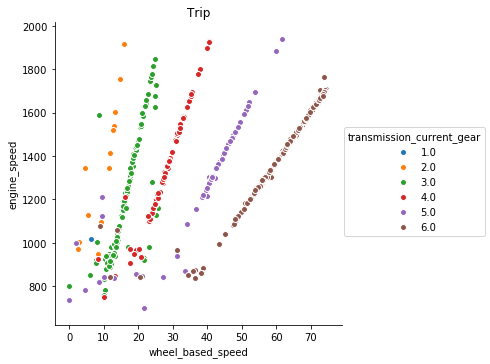

In [55]:
plot_trip_info(trip[4])